In [1]:
from lenskit.metrics import dataGenerator
from lenskit import batch, topn, util, topnFair
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, user_knn as knn
from lenskit import topn, topnFair

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
import math

In [4]:
#ratings = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/ratings.1.csv', sep=',',
#                      names=['user', 'item', 'rating', 'timestamp'], header=0)

#items = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
#                      names=['movieId','title','genres'], header=0)

ratings = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/ratings.csv', sep=',',
                      names=['user', 'item', 'rating', 'timestamp'], header=0)

items = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
                      names=['item','title','genres'], header=0)

#C:\Users\josse\Git-kode projects\Speciale\Fair-Recommendations\ml-latest-small\ratings.csv

In [5]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
item      9125 non-null int64
title     9125 non-null object
genres    9125 non-null object
dtypes: int64(1), object(2)
memory usage: 213.9+ KB


In [6]:
items_dummy = pd.concat([items, items['genres'].str.get_dummies(sep='|')], axis=1)
items_dummy.head()

,item,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
algo_ii = knn.UserUser(20)
algo_als = als.BiasedMF(50)

In [8]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [9]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 1, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))
   
    

In [10]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs_joined = all_recs.join(items_dummy.set_index('item'), on='item')
all_recs_joined.head()

,item,score,user,rank,Algorithm,title,genres,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,107559,5.272887,1,1,ItemItem,Am Ende eiens viel zu kurzen Tages (Death of a...,Animation|Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,73290,5.272887,1,2,ItemItem,Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's ...,Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,106441,5.272887,1,3,ItemItem,"Book Thief, The (2013)",Children|Drama|War,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3216,5.013170,1,4,ItemItem,"Vampyros Lesbos (Vampiras, Las) (1971)",Fantasy|Horror|Thriller,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,92494,5.013170,1,5,ItemItem,Dylan Moran: Monster (2004),Comedy|Documentary,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
test_data = pd.concat(test_data, ignore_index=True)
test_data.head()

,user,item,rating
0,1,1263,2.0
1,1,1293,2.0
2,1,2455,2.5
3,1,1371,2.5
4,2,144,3.0


In [12]:
_protected_group2 = all_recs_joined.loc[all_recs_joined['Action'] == 1]
_protected_group2.head()
_protected_group2['item'].values

array([  4396, 111781,   7787, ...,  85414, 112852,  49272], dtype=int64)

In [13]:
recs_temp = all_recs_joined.iloc[100:110,:]
recs_temp 


,item,score,user,rank,Algorithm,title,genres,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
100,107559,6.156084,2,1,ItemItem,Am Ende eiens viel zu kurzen Tages (Death of a...,Animation|Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,73290,6.156084,2,2,ItemItem,Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's ...,Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,4754,5.896367,2,3,ItemItem,"Wicker Man, The (1973)",Drama|Horror|Mystery|Thriller,0,0,0,...,0,1,0,0,1,0,0,1,0,0
103,3216,5.896367,2,4,ItemItem,"Vampyros Lesbos (Vampiras, Las) (1971)",Fantasy|Horror|Thriller,0,0,0,...,0,1,0,0,0,0,0,1,0,0
104,92494,5.896367,2,5,ItemItem,Dylan Moran: Monster (2004),Comedy|Documentary,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,4302,5.872535,2,6,ItemItem,"King Is Alive, The (2000)",Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,5071,5.872535,2,7,ItemItem,Maelström (2000),Drama|Romance,0,0,0,...,0,0,0,0,0,1,0,0,0,0
107,3320,5.872535,2,8,ItemItem,Mifune's Last Song (Mifunes sidste sang) (1999),Comedy|Drama|Romance,0,0,0,...,0,0,0,0,0,1,0,0,0,0
108,86781,5.872535,2,9,ItemItem,Incendies (2010),Drama|Mystery|War,0,0,0,...,0,0,0,0,1,0,0,0,1,0
109,4731,5.872535,2,10,ItemItem,Innocence (2000),Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
def calculate_demParity(recs, protected_group): 
    #beslut hvad der er nemmest. Skal denne tage "protected group". contains eller tage en protected variabel?
    
    exposure_pro = 0; 
    exposure_unpro = 0;
    print(_protected_group2['item'].values)

    for index, row in recs.iterrows():
        if row["item"] in _protected_group2['item'].values:
            print(row["item"], "in protected group")
            exposure_pro = exposure_pro + (1/math.log2(1+row["rank"])) 
        else:
            exposure_unpro = exposure_unpro + (1/math.log2(1+row["rank"]))  
   
    return abs(exposure_pro-exposure_unpro)

In [15]:
x = calculate_demParity(recs_temp, _protected_group2)
x 

[  4396 111781   7787 ...  85414 112852  49272]


4.543559338088346

In [16]:
# user , algorithms = iput to group_cols --> de koloner der skal  groupes på 
# res: categories of protected variable 
res= list(all_recs_joined.iloc[:,8:])
res1= all_recs_joined.item.nunique()
res2 =  all_recs_joined.loc[ all_recs_joined['Horror'] == 1]
print(res)

rla = topnFair.FairRecListAnalysis(['user', "Algorithm"])
rla.add_metric("rND")
rla.add_metric("rKL")
rla.add_metric("rRD")
rla.add_metric("div")
rla.add_metric("dem_parity")
results = rla.compute(all_recs_joined, test_data, "Horror", res, res1, res2.item.nunique())
results.head()

['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.044444444444444446 qx:  0.07717980809345015
0.012667490898684713
100
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.06666666666666667 qx:  0.077179808093

0.000342926039150036
80
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
90
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
100
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
100
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
10
px:  0.3 qx:  0.07717980809345015
0.3085138870992516
20
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
30
px:  0.16666666666666666 qx:  0.0771

px:  0.05555555555555555 qx:  0.07717980809345015
0.005210328137345045
100
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.07777777777777778 qx:  0.07717980809345015
3.612909492904876e-06
100
px:  0.07 qx:  0.07717980809345015
0.0005376671944903391
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809

10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.07142857142857142 qx:  0.07717980809345015
0.000342926039150036
80
px:  0.0625 qx:  0.07717980809345015
0.0023230949048116296
90
px:  0.05555555555555555 qx:  0.07717980809345015
0.005210328137345045
100
px:  0.07 qx:  0.07717980809345015
0.0005376671944903391
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.077

px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.07142857142857142 qx:  0.07717980809345015
0.000342926039150036
80
px:  0.0625 qx:  0.07717980809345015
0.0023230949048116296
90
px:  0.05555555555555555 qx:  0.07717980809345015
0.005210328137345045
100
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.0625 qx:  0

100
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.08333333333333333 qx:  0.07717980809345015
0.0003745239206583359
70
px:  0.08571428571428572 qx:  0.07717980809345015
0.0007140816499923378
80
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
90
px:  0.12222222222222222 qx:  0.07717980809345015
0.01768901839479274
100
px:  0.13 qx:  0.07717980809345015
0.02380838564982818
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316


px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.0125 qx:  0.07717980809345015
0.06368084497343285
90
px:  0.05555555555555555 qx:  0.07717980809345015
0.005210328137345045
100
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.0125 qx:  0.07717980809345015
0.06368084497343285
90
px:  0.011111111111111112 qx:  0.07717980809345015
0.06758131114839332
100
px:  0.01 qx:  0.07717980809345015
0.07088292961569868
10
px:  0.

10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.022222222222222223 qx:  0.07717980809345015
0.04168643663496166
100
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
10
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
20
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
30
px:  0.13333333333333333 qx:  0.07717980809345015
0.026669578157306653
40
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.001169

px:  0.011111111111111112 qx:  0.07717980809345015
0.06758131114839332
100
px:  0.01 qx:  0.07717980809345015
0.07088292961569868
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
30
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.08333333333333333 qx:  0.07717980809345015
0.0003745239206583359
70
px:  0.07142857142857142 qx:  0.07717980809345015
0.000342926039150036
80
px:  0.0875 qx:  0.07717980809345015
0.0010373875354791062
90
px:  0.08888888888888889 qx:  0.07717980809345015
0.001328738822862597
100
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
10
px:  0.3 qx:  0.07717980809345015
0.3085138870992516
20
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
30
px:  0.16666666666666666 qx:  0.07717980809345015
0.06248180338580425
40
px:  0.15 qx:  0.07717980809345015
0.04300

10
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
50
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
60
px:  0.13333333333333333 qx:  0.07717980809345015
0.026669578157306653
70
px:  0.14285714285714285 qx:  0.07717980809345015
0.035599203363297846
80
px:  0.175 qx:  0.07717980809345015
0.07331967505858747
90
px:  0.15555555555555556 qx:  0.07717980809345015
0.04915897004671212
100
px:  0.16 qx:  0.07717980809345015
0.054329642328803066
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
60
px:  0.001 qx:  0.07717980809345015
0.10805051988668306


px:  0.1 qx:  0.07717980809345015
0.004858350796984177
60
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
70
px:  0.08571428571428572 qx:  0.07717980809345015
0.0007140816499923378
80
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
90
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
100
px:  0.07 qx:  0.07717980809345015
0.0005376671944903391
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.044444444444444446 qx:  0.07717980809345015
0.012667490898684713
100
px:  0.04 qx:  0.07717980809345015
0.016776502720

px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
50
px:  0.14 qx:  0.07717980809345015
0.032805301132145345
60
px:  0.13333333333333333 qx:  0.07717980809345015
0.026669578157306653
70
px:  0.12857142857142856 qx:  0.07717980809345015
0.02262537063777982
80
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
90
px:  0.14444444444444443 qx:  0.07717980809345015
0.037193034814537326
100
px:  0.14 qx:  0.07717980809345015
0.032805301132145345
10
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
20
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
30
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.08333333333333333 qx:  0.07717980809345015
0.000374

50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.08571428571428572 qx:  0.07717980809345015
0.0007140816499923378
80
px:  0.125 qx:  0.07717980809345015
0.019783356429628876
90
px:  0.12222222222222222 qx:  0.07717980809345015
0.01768901839479274
100
px:  0.12 qx:  0.07717980809345015
0.016088163293268926
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.022222222222222223 qx:  0.07717980809345015
0.04168643663496166
100
px:

px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.0125 qx:  0.07717980809345015
0.06368084497343285
90
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
100
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
10
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
20
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
30
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353


80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
100
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
10
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.08333333333333333 qx:  0.07717980809345015
0.0003745239206583359
70
px:  0.11428571428571428 qx:  0.07717980809345015
0.012284148208508254
80
px:  0.175 qx:  0.07717980809345015
0.07331967505858747
90
px:  0.16666666666666666 qx:  0.07717980809345015
0.06248180338580425
100
px:  0.17 qx:  0.07717980809345015
0.06673196032233361
10
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.0771798080934

px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
70
px:  0.08571428571428572 qx:  0.07717980809345015
0.0007140816499923378
80
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
90
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
100
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.0125 qx:  0.07717980809345015
0.06368084497343285
90
px:  0.022222222222222223 qx:  0.0771798080934

px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.0125 qx:  0.07717980809345015
0.06368084497343285
90
px:  0.022222222222222223 qx:  0.07717980809345015
0.04168643663496166
100
px:  0.03 qx:  0.07717980809345015
0.02887929187440158
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.08333333333333333 qx:  0.07717980809345015
0.000

px:  0.15 qx:  0.07717980809345015
0.04300135015578471
30
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.08333333333333333 qx:  0.07717980809345015
0.0003745239206583359
70
px:  0.07142857142857142 qx:  0.07717980809345015
0.000342926039150036
80
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
90
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
100
px:  0.07 qx:  0.07717980809345015
0.0005376671944903391
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345

px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.08571428571428572 qx:  0.07717980809345015
0.0007140816499923378
80
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
90
px:  0.08888888888888889 qx:  0.07717980809345015
0.001328738822862597
100
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.

px:  0.12 qx:  0.07717980809345015
0.016088163293268926
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.044444444444444446 qx:  0.07717980809345015
0.012667490898684713
100
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
6

40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.1125 qx:  0.07717980809345015
0.0111899083430484
90
px:  0.13333333333333333 qx:  0.07717980809345015
0.026669578157306653
100
px:  0.16 qx:  0.07717980809345015
0.054329642328803066
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.022222222222222223 qx:  0.07717980809345015


px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.08571428571428572 qx:  0.07717980809345015
0.0007140816499923378
80
px:  0.125 qx:  0.07717980809345015
0.019783356429628876
90
px:  0.14444444444444443 qx:  0.07717980809345015
0.037193034814537326
100
px:  0.16 qx:  0.07717980809345015
0.054329642328803066
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.025 qx:  0.07717980809345015
0.036711

px:  0.1 qx:  0.07717980809345015
0.004858350796984177
100
px:  0.12 qx:  0.07717980809345015
0.016088163293268926
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.044444444444444446 qx:  0.07717980809345015
0.012667490898684713
100
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.0367

60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.022222222222222223 qx:  0.07717980809345015
0.04168643663496166
100
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.044444444444444446 qx:  0.07717980809345015
0.012667490898684713
100
px:  0.07 qx:  0.07717980809345015
0.0005376671944903391
10
px:  0.0

px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.0875 qx:  0.07717980809345015
0.0010373875354791062
90
px:  0.07777777777777778 qx:  0.07717980809345015
3.612909492904876e-06
100
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.077179808

90
px:  0.13333333333333333 qx:  0.07717980809345015
0.026669578157306653
100
px:  0.14 qx:  0.07717980809345015
0.032805301132145345
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.044444444444444446 qx:  0.07717980809345015
0.012667490898684713
100
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.05 qx:  0.07717980809345015
0.0084

px:  0.001 qx:  0.07717980809345015
0.10805051988668306
60
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
70
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
80
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
90
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
100
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
10
px:  0.3 qx:  0.07717980809345015
0.3085138870992516
20
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
30
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.0875 qx:  0.07717980809345015
0.0010373875354791062
90
px:  0.07777777777777778 qx:  0.07717980809345015
3.612909492904876e-06
100
px:  0.11 qx:  0.07717980809345015
0.009735528318921355
10
px:  0.0

20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.07777777777777778 qx:  0.07717980809345015
3.612909492904876e-06
100
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.05714285714285714 qx:  0.07717980809

px:  0.0875 qx:  0.07717980809345015
0.0010373875354791062
90
px:  0.07777777777777778 qx:  0.07717980809345015
3.612909492904876e-06
100
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.044444444444444446 qx:  0.07717980809345015
0.012667490898684713
100
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0

50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.044444444444444446 qx:  0.07717980809345015
0.012667490898684713
100
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
30
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
90
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
100
px:  0.12 qx:  0.07717980809345015
0.016088163293268926


px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.08333333333333333 qx:  0.07717980809345015
0.0003745239206583359
70
px:  0.08571428571428572 qx:  0.07717980809345015
0.0007140816499923378
80
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
90
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
100
px:  0.07 qx:  0.07717980809345015
0.0005376671944903391
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.

80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
100
px:  0.07 qx:  0.07717980809345015
0.0005376671944903391
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.07142857142857142 qx:  0.07717980809345015
0.000342926039150036
80
px:  0.0625 qx:  0.07717980809345015
0.0023230949048116296
90
px:  0.05555555555555555 qx:  0.07717980809345015
0.005210328137345045
100
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.

px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.022222222222222223 qx:  0.07717980809345015
0.04168643663496166
100
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.07777777777777778 qx:  0.07

10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.07777777777777778 qx:  0.07717980809345015
3.612909492904876e-06
100
px:  0.09 qx:  0.07717980809345015
0.0015865852249784644
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.06666666666666667 qx:  0.077

px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.022222222222222223 qx:  0.07717980809345015
0.04168643663496166
100
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.022222222222222223 qx:  0.07717980809345015
0.04168643663496166
100
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
10
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
20
px:  0.15 qx:  0.07717980809345015
0.0430013

40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
60
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
70
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
80
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
90
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
100
px:  0.01 qx:  0.07717980809345015
0.07088292961569868
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
90
px:  0.08888888888888889 qx:  0.07717980809345015
0.00132873882286

px:  0.03 qx:  0.07717980809345015
0.02887929187440158
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.08333333333333333 qx:  0.07717980809345015
0.0003745239206583359
70
px:  0.07142857142857142 qx:  0.07717980809345015
0.000342926039150036
80
px:  0.0875 qx:  0.07717980809345015
0.0010373875354791062
90
px:  0.12222222222222222 qx:  0.07717980809345015
0.01768901839479274
100
px:  0.14 qx:  0.07717980809345015
0.032805301132145345
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.001 qx:  0.07717980809345015
0.1080505198866830

70
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
80
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
90
px:  0.13333333333333333 qx:  0.07717980809345015
0.026669578157306653
100
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
90
px:  0.07777777777777778 qx:  0.07717980809345015
3.612909492904876e-06
100
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438

px:  0.16666666666666666 qx:  0.07717980809345015
0.06248180338580425
40
px:  0.125 qx:  0.07717980809345015
0.019783356429628876
50
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
60
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
70
px:  0.08571428571428572 qx:  0.07717980809345015
0.0007140816499923378
80
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
90
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
100
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
10
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.05 qx:  0.07717980809

100
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.07777777777777778 qx:  0.07717980809345015
3.612909492904876e-06
100
px:  0.09 qx:  0.07717980809345015
0.0015865852249784644
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.06 qx:  0.07717980809345015
0.003218

px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.08888888888888889 qx:  0.07717980809345015
0.001328738822862597
100
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
60
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
70
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
80
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
90
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
100
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.0771798

30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.0125 qx:  0.07717980809345015
0.06368084497343285
90
px:  0.022222222222222223 qx:  0.07717980809345015
0.04168643663496166
100
px:  0.03 qx:  0.07717980809345015
0.02887929187440158
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.0625 qx:  0.07717980809345015
0.

px:  0.011111111111111112 qx:  0.07717980809345015
0.06758131114839332
100
px:  0.01 qx:  0.07717980809345015
0.07088292961569868
10
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.0625 qx:  0.07717980809345015
0.0023230949048116296
90
px:  0.07777777777777778 qx:  0.07717980809345015
3.612909492904876e-06
100
px:  0.09 qx:  0.07717980809345015
0.0015865852249784644
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03

60
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
70
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
80
px:  0.1125 qx:  0.07717980809345015
0.0111899083430484
90
px:  0.12222222222222222 qx:  0.07717980809345015
0.01768901839479274
100
px:  0.12 qx:  0.07717980809345015
0.016088163293268926
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
100
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.1 qx: 

px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
60
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.0125 qx:  0.07717980809345015
0.06368084497343285
90
px:  0.011111111111111112 qx:  0.07717980809345015
0.06758131114839332
100
px:  0.01 qx:  0.07717980809345015
0.07088292961569868
10
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.07142857142857142 qx:  0.07717980809345015
0.0003

90
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
100
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.08333333333333333 qx:  0.07717980809345015
0.0003745239206583359
70
px:  0.07142857142857142 qx:  0.07717980809345015
0.000342926039150036
80
px:  0.0875 qx:  0.07717980809345015
0.0010373875354791062
90
px:  0.1111111111111111 qx:  0.07717980809345015
0.01037065638526849
100
px:  0.11 qx:  0.07717980809345015
0.009735528318921355
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.0771

px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.08888888888888889 qx:  0.07717980809345015
0.001328738822862597
100
px:  0.11 qx:  0.07717980809345015
0.009735528318921355
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.044444444444444446 qx:  0.07717980809345015
0.012667490898684713
100
px:  0.04

20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
100
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.0771798080

px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.022222222222222223 qx:  0.07717980809345015
0.04168643663496166
100
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
100
px:  0.03 qx:  0.07717980809345015
0.02887929187440158
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
4

50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.044444444444444446 qx:  0.07717980809345015
0.012667490898684713
100
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.044444444444444446 qx:  0.07717980809345015
0.012667490898684713
100
px:  0.05 qx:  0.07717980

px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.25 qx:  0.07717980809345015
0.1995389513848918
30
px:  0.16666666666666666 qx:  0.07717980809345015
0.06248180338580425
40
px:  0.125 qx:  0.07717980809345015
0.019783356429628876
50
px:  0.14 qx:  0.07717980809345015
0.032805301132145345
60
px:  0.13333333333333333 qx:  0.07717980809345015
0.026669578157306653
70
px:  0.11428571428571428 qx:  0.07717980809345015
0.012284148208508254
80
px:  0.125 qx:  0.07717980809345015
0.019783356429628876
90
px:  0.1111111111111111 qx:  0.07717980809345015
0.01037065638526849
100
px:  0.11 qx:  0.07717980809345015
0.009735528318921355
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.08333333333333333 qx:  0.0771798080934

80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
100
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
10
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.0625 qx:  0.07717980809345015
0.0023230949048116296
90
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
100
px:  0.09 qx:  0.07717980809345015
0.0015865852249784644
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.108050519

px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
90
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
100
px:  0.11 qx:  0.07717980809345015
0.009735528318921355
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.03333333333333333 qx:  0.07717980809

10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.022222222222222223 qx:  0.07717980809345015
0.04168643663496166
100
px:  0.03 qx:  0.07717980809345015
0.02887929187440158
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.077179808093

px:  0.001 qx:  0.07717980809345015
0.10805051988668306
80
px:  0.0125 qx:  0.07717980809345015
0.06368084497343285
90
px:  0.011111111111111112 qx:  0.07717980809345015
0.06758131114839332
100
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
10
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
20
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
30
px:  0.13333333333333333 qx:  0.07717980809345015
0.026669578157306653
40
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
70
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
80
px:  0.1125 qx:  0.07717980809345015
0.0111899083430484
90
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
100
px:  0.09 qx:  0.07717980809345015
0.0015865852249784644
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809

40
px:  0.125 qx:  0.07717980809345015
0.019783356429628876
50
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
60
px:  0.08333333333333333 qx:  0.07717980809345015
0.0003745239206583359
70
px:  0.08571428571428572 qx:  0.07717980809345015
0.0007140816499923378
80
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
90
px:  0.12222222222222222 qx:  0.07717980809345015
0.01768901839479274
100
px:  0.12 qx:  0.07717980809345015
0.016088163293268926
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.03333333333333333 

px:  0.1 qx:  0.07717980809345015
0.004858350796984177
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.07777777777777778 qx:  0.07717980809345015
3.612909492904876e-06
100
px:  0.07 qx:  0.07717980809345015
0.0005376671944903391
10
px:  0.3 qx:  0.07717980809345015
0.3085138870992516
20
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
30
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.06666

70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
100
px:  0.03 qx:  0.07717980809345015
0.02887929187440158
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
100
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.0771798

px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
80
px:  0.1375 qx:  0.07717980809345015
0.03044082389714213
90
px:  0.13333333333333333 qx:  0.07717980809345015
0.026669578157306653
100
px:  0.12 qx:  0.07717980809345015
0.016088163293268926
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.0125 qx:  0.07717980809345015
0.0636

100
px:  0.09 qx:  0.07717980809345015
0.0015865852249784644
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
100
px:  0.03 qx:  0.07717980809345015
0.02887929187440158
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.016776502720746

px:  0.001 qx:  0.07717980809345015
0.10805051988668306
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
100
px:  0.03 qx:  0.07717980809345015
0.02887929187440158
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.0625 qx:  0.07717980809345015
0.0023230949048116296
90
px:  0.07777777777777778 qx:  0.07717980809345015
3.612909492904876e-06
100
px:  0.07 qx:  0.07717980809345015
0.0005376671944903391
10
px:  0.001 qx:  0.0771

30
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.0625 qx:  0.07717980809345015
0.0023230949048116296
90
px:  0.07777777777777778 qx:  0.07717980809345015
3.612909492904876e-06
100
px:  0.09 qx:  0.07717980809345015
0.0015865852249784644
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.05 qx:  0.077179808093450

px:  0.011111111111111112 qx:  0.07717980809345015
0.06758131114839332
100
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.0125 qx:  0.07717980809345015
0.06368084497343285
90
px:  0.011111111111111112 qx:  0.07717980809345015
0.06758131114839332
100
px:  0.01 qx:  0.07717980809345015
0.07088292961569868
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.05 qx:  0.0771798080

60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.022222222222222223 qx:  0.07717980809345015
0.04168643663496166
100
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
90
px:  0.08888888888888889 qx:  0.07717980809345015
0.001328738822862597
100
px:  0.11 qx:  0.07717980809345015
0.009735528318921355
10
px:  0.0

px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.08333333333333333 qx:  0.07717980809345015
0.0003745239206583359
70
px:  0.08571428571428572 qx:  0.07717980809345015
0.0007140816499923378
80
px:  0.0875 qx:  0.07717980809345015
0.0010373875354791062
90
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
100
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345015


90
px:  0.12222222222222222 qx:  0.07717980809345015
0.01768901839479274
100
px:  0.11 qx:  0.07717980809345015
0.009735528318921355
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.0125 qx:  0.07717980809345015
0.06368084497343285
90
px:  0.011111111111111112 qx:  0.07717980809345015
0.06758131114839332
100
px:  0.01 qx:  0.07717980809345015
0.07088292961569868
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.

px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.044444444444444446 qx:  0.07717980809345015
0.012667490898684713
100
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
90
px:  0.1111111111111111 qx:  0.07717980809345015
0.01037065638526849
100
px:  0.13 q

20
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
30
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.11666666666666667 qx:  0.07717980809345015
0.013813728043933195
70
px:  0.11428571428571428 qx:  0.07717980809345015
0.012284148208508254
80
px:  0.1125 qx:  0.07717980809345015
0.0111899083430484
90
px:  0.1111111111111111 qx:  0.07717980809345015
0.01037065638526849
100
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980

px:  0.0875 qx:  0.07717980809345015
0.0010373875354791062
90
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
100
px:  0.12 qx:  0.07717980809345015
0.016088163293268926
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.0125 qx:  0.07717980809345015
0.06368084497343285
90
px:  0.011111111111111112 qx:  0.07717980809345015
0.06758131114839332
100
px:  0.03 qx:  0.07717980809345015
0.02887929187440158
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
30
px:  0.13333333333333333 qx:  0.07717980809345015
0.026669578157306

50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.0125 qx:  0.07717980809345015
0.06368084497343285
90
px:  0.022222222222222223 qx:  0.07717980809345015
0.04168643663496166
100
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.05555555555555555 qx:  0.07717980809345015
0.005210328137345045
100
px:  0.

px:  0.2 qx:  0.07717980809345015
0.10990127047074255
20
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
30
px:  0.13333333333333333 qx:  0.07717980809345015
0.026669578157306653
40
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
70
px:  0.07142857142857142 qx:  0.07717980809345015
0.000342926039150036
80
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
90
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
100
px:  0.09 qx:  0.07717980809345015
0.0015865852249784644
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
60
px:  0.08333333333333333 qx:  0.07717980809345015
0.00037452392065833

80
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
90
px:  0.08888888888888889 qx:  0.07717980809345015
0.001328738822862597
100
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
60
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
70
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
80
px:  0.0125 qx:  0.07717980809345015
0.06368084497343285
90
px:  0.011111111111111112 qx:  0.07717980809345015
0.06758131114839332
100
px:  0.01 qx:  0.07717980809345015
0.07088292961569868
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px: 

px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.044444444444444446 qx:  0.07717980809345015
0.012667490898684713
100
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.0875 qx:  0.07717980809345015
0.0010373875354791062
90
px:  0.07777777777777778 q

10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.0625 qx:  0.07717980809345015
0.0023230949048116296
90
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
100
px:  0.07 qx:  0.07717980809345015
0.0005376671944903391
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
40
px:  0.125 qx:  0.07717980809345015
0.019783356429628876
50
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
60
px:  0.1 qx:  0.07717980809345015
0.00485835079

px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.0625 qx:  0.07717980809345015
0.0023230949048116296
90
px:  0.1111111111111111 qx:  0.07717980809345015
0.01037065638526849
100
px:  0.13 qx:  0.07717980809345015
0.02380838564982818
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.05555555555555555 qx:  0.07717980809345015
0.005210328137345045
100
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.1 qx:  0.0771798080

40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.014285714285714285 qx:  0.07717980809345015
0.058994674003917655
80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.022222222222222223 qx:  0.07717980809345015
0.04168643663496166
100
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.125 qx:  0.07717980809345015
0.019783356429628876
90
px:  0.1222222222222222

px:  0.06 qx:  0.07717980809345015
0.00321885684305339
10
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
20
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
30
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.08333333333333333 qx:  0.07717980809345015
0.0003745239206583359
70
px:  0.08571428571428572 qx:  0.07717980809345015
0.0007140816499923378
80
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
90
px:  0.06666666666666667 qx:  0.07717980809345015
0.0011694690408976353
100
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.0166

70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.05555555555555555 qx:  0.07717980809345015
0.005210328137345045
100
px:  0.08 qx:  0.07717980809345015
7.966998962480581e-05
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
60
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
70
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
80
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
90
px:  0.011111111111111112 qx:  0.07717980809345015
0.06758131114839332
100
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
30
px:  0.06

px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.0375 qx:  0.07717980809345015
0.019409350587389358
90
px:  0.044444444444444446 qx:  0.07717980809345015
0.012667490898684713
100
px:  0.04 qx:  0.07717980809345015
0.01677650272074694
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.05 qx:  0.07717980809

100
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
10
px:  0.2 qx:  0.07717980809345015
0.10990127047074255
20
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
30
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
60
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
70
px:  0.08571428571428572 qx:  0.07717980809345015
0.0007140816499923378
80
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
90
px:  0.08888888888888889 qx:  0.07717980809345015
0.001328738822862597
100
px:  0.09 qx:  0.07717980809345015
0.0015865852249784644
10
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
20
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666

px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
90
px:  0.05555555555555555 qx:  0.07717980809345015
0.005210328137345045
100
px:  0.09 qx:  0.07717980809345015
0.0015865852249784644
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
30
px:  0.03333333333333333 qx:  0.07717980809345015
0.02436136341984045
40
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
50
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.02857142857142857 qx:  0.07717980809345015
0.030980958247457703
80
px:  0.025 qx:  0.07717980809345015
0.03671144716071569
90
px:  0.022222222222222223 qx:  0.07717980809345015
0.04168643663496166
100
px:  0.02 qx:  0.07717980809345015
0.04603306506697316
10
px:  0.1 qx:  0.077179808093

30
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
40
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
50
px:  0.001 qx:  0.07717980809345015
0.10805051988668306
60
px:  0.016666666666666666 qx:  0.07717980809345015
0.053249496507024624
70
px:  0.04285714285714286 qx:  0.07717980809345015
0.014054447783593861
80
px:  0.0625 qx:  0.07717980809345015
0.0023230949048116296
90
px:  0.05555555555555555 qx:  0.07717980809345015
0.005210328137345045
100
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
10
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
20
px:  0.15 qx:  0.07717980809345015
0.04300135015578471
30
px:  0.1 qx:  0.07717980809345015
0.004858350796984177
40
px:  0.075 qx:  0.07717980809345015
4.854501680858327e-05
50
px:  0.06 qx:  0.07717980809345015
0.00321885684305339
60
px:  0.05 qx:  0.07717980809345015
0.00846927678438951
70
px:  0.05714285714285714 qx:  0.07717980809345015
0.004438773848480924
80
px:  0.05 qx:  0.07717980809345015
0.00846927678438

rND       rKL       rRD       div  dem_parity
user Algorithm                                                    
1    ALS        0.069014  0.048495  0.077231  0.947368    0.046462
     ItemItem   0.056209  0.022153  0.037717  0.894737    0.136570
2    ALS        0.070985  0.035595  0.072325  1.000000    0.068628
     ItemItem   0.065519  0.039377  0.024128  0.894737    0.108972
3    ALS        0.103997  0.115310  0.114139  0.947368    0.041444

In [17]:
results.groupby('Algorithm').rND.mean()

Algorithm
ALS         0.102276
ItemItem    0.071691
Name: rND, dtype: float64

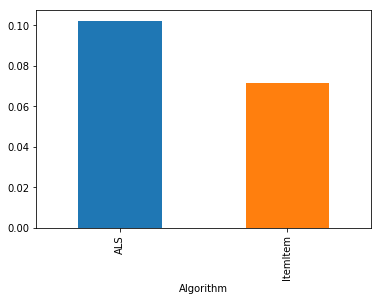

In [18]:
results.groupby('Algorithm').rND.mean().plot.bar()


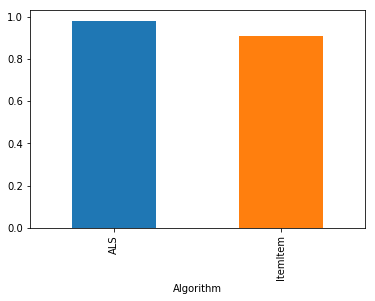

In [19]:
results.groupby('Algorithm').div.mean().plot.bar()